In [26]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
import csv
import os

import torch.profiler

np.random.seed(1234)

In [27]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce GTX 1650


In [28]:
profiler_config = torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log'),
    record_shapes=True,
    profile_memory=True,
    with_stack=True
)

In [29]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# device = torch.device("cpu")
# print(device)

torch.backends.cudnn.benchmark = True

Using device: cuda


In [30]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)
    

# class DNN(nn.Module):
#     def __init__(self, layers):
#         super(DNN, self).__init__()
#         modules = []
#         for i in range(len(layers) - 2):  # Exclude last layer for activation
#             modules.append(nn.Linear(layers[i], layers[i+1]))
#             modules.append(nn.Tanh())
#         modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
#         self.network = nn.Sequential(*modules)

#     def forward(self, x):
#         return self.network(x)

In [31]:
layers = [1, 20, 20, 20, 1]
model = DNN(layers)

print(model)

DNN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation): Tanh()
)


In [32]:
lbfgs_lr = 0.1
adam_lr = 0.01

w_pde = 1
w_bc = 1

In [35]:
class PINN():
    def __init__(self, X, layers, lb, rb, q_c):
        
        self.x = torch.tensor(X, requires_grad=True).float().to(device)
        self.q_c = torch.tensor(q_c).float().to(device)

        self.lb = lb
        self.rb = rb

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.iter = 0
        self.loss_count = 0

    def model_value(self, x):
        u = self.dnn(x)
        return u
    
    def boundary_condition(self, cond, u, u_x, u_2x, u_3x):
        bc_loss = 0

        match cond:
            case 'pinned':
                bc_loss += u**2 + u_2x**2
            case 'fixed':
                bc_loss += u**2 + u_x**2
            case 'free':
                bc_loss += u_2x**2 + u_3x**2
            case 'roller':
                bc_loss += u_x**2 + u_3x**2

        return bc_loss
    
    def loss_func(self, x):
        self.loss_count += 1
        u = self.model_value(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_3x = torch.autograd.grad(u_2x, x, torch.ones_like(u_2x), create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x, x, torch.ones_like(u_3x), create_graph=True)[0]

        # BC
        bc_loss = self.boundary_condition(self.lb, u[0], u_x[0], u_2x[0], u_3x[0])
        bc_loss += self.boundary_condition(self.rb, u[-1], u_x[-1], u_2x[-1], u_3x[-1])

        # PDE
        pde_loss = torch.mean((u_4x - self.q_c)**2)

        return pde_loss, bc_loss


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func(self.x)
        loss = w_pde*pde_loss + w_bc*bc_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        
        if self.iter % 500 == 0:
            print(f"Iter: {self.iter}, PDE loss: {'{:e}'.format(pde_loss.item())}, BC loss: {'{:e}'.format(bc_loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        with profiler_config as prof:
            for epoch in range(epochs):
                pde_loss, bc_loss = self.loss_func(self.x)
                loss = w_pde*pde_loss + w_bc*bc_loss

                self.optimizer_adam.zero_grad()
                loss.backward()
                self.optimizer_adam.step()

                prof.step()

                if epoch % 500 == 0:
                    print(f"Epoch: {epoch}, PDE loss: {'{:e}'.format(pde_loss.item())}, BC loss: {'{:e}'.format(bc_loss.item())}")

        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, X, q_c, L, EI):
        x = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u_c = self.model_value(x)
        u_c = u_c.detach().cpu().numpy()
        u = (q_c * L**4 / (EI)) * u_c

        pde_loss, bc_loss = self.loss_func(self.x)
        final_loss = w_pde*pde_loss + w_bc*bc_loss
        final_loss = final_loss.detach().cpu().numpy()
        return u, final_loss[0]

# Parameters

In [36]:
EI = 11.57e10*0.1**4/12
Q = -1.0e6
L = 3.0

print(EI)

964166.6666666669


# Exact solutions

In [37]:
q1 = lambda x: Q / (24*EI) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q
q2 = lambda x: Q / (120*EI) * (x**5/L - 10*L*x**3 + 20*L**2*x**2) # Fixed, free, increasing q
q3 = lambda x: Q / (120*EI) * (-x**5/L + 5*x**4 - 10*L*x**3 + 10*L**2*x**2) # Fixed, free, decreasing q
q4 = lambda x: Q / (24*EI) * (x**4/L - 2*x**3 + x/L**2) # Pinned, pinned, constant q
q5 = lambda x: Q / (180*EI) * (3*x**5/L**2 - 10*x**3 + 7*L**2*x) # Pinned, pinned, increasing q
q6 = lambda x: Q / (180*EI) * (-3*x**5/L**2 + 15*x**4/L - 20*x**3 + 8*L**2*x) # Pinned, pinned, decreasing q
q7 = lambda x: Q / (48*EI) * (2*x**4 - 5*L*x**3 + 3*L**2*x**2) # Fixed, pinned, constant q
exact_dict = {
    "fixed_free_constant": q1,
    "fixed_free_increasing": q2,
    "fixed_free_decreasing": q3,
    "pinned_pinned_constant": q4,
    "pinned_pinned_increasing": q5,
    "pinned_pinned_decreasing": q6,
    "fixed_pinned_constant": q7,
}


In [38]:
qx1 = lambda x: np.full_like(x, Q/L) # Constant
qx2 = lambda x: Q*2/L**2 * x # Increasing
qx3 = lambda x: Q*2/L**2 * (L - x) # Decrasing

In [39]:
n_points = 100
epochs = 1000

# x_t = np.random.uniform(0, L, n_points-2)
x_t = np.linspace(0, L, n_points-2)
x_t = np.append(x_t, [0, L])
x_t = np.sort(x_t).reshape(-1, 1)

q = qx2(x_t)

x_hat = x_t / L
q_c = np.max(np.abs(q))

q_hat = q / q_c


nodes = 20
layers = [1, nodes, nodes, nodes, 1]
lb = 'pinned'
rb = 'pinned'

model = PINN(x_hat, layers, lb, rb, q_hat)


In [40]:
print(model.dnn)
num_params = sum(p.numel() for p in model.dnn.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

DNN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation): Tanh()
)
Total trainable parameters: 901


In [24]:
a = torch.randn(10, 10, device=device)
b = torch.randn(10, 10, device=device)

# Warm-up: run a dummy operation to initialize the GPU and CUDA context
c = torch.mm(a, b)

In [41]:
%%time

model.train(epochs)

Epoch: 0, PDE loss: 5.391415e-01, BC loss: 4.594031e-02
Epoch: 500, PDE loss: 1.406991e-05, BC loss: 1.092321e-08
Iter: 0, PDE loss: 7.834755e-06, BC loss: 4.620247e-09
CPU times: total: 23.6 s
Wall time: 59.4 s


In [52]:
# Print a summary table
print(profiler_config.key_averages().table(sort_by="cuda_time_total", row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         5.78%      21.313ms         8.01%      29.569ms       9.856ms     424.945ms        53.38%     433.235ms     144.412ms           0 b         400 b    -595.00 Kb    -587.50 K

In [42]:
x = np.linspace(0, L, n_points).reshape(-1, 1)
u_pred, final_loss = model.predict(x/L, q_c, L, EI)
u_pred = u_pred.flatten()
u_exact = q5(x.flatten())

u_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact,2)
abs_error = np.abs(u_pred - u_exact)
max_error = np.max(abs_error)


print(f"L2 Error: {u_error:.3e}")
print(f"Final loss: {final_loss:.3e}")
print(f"Max absolute error: {max_error:.3e}")
print(model.loss_count)

L2 Error: 3.621e-04
Final loss: 2.266e-07
Max absolute error: 1.736e-04
1144


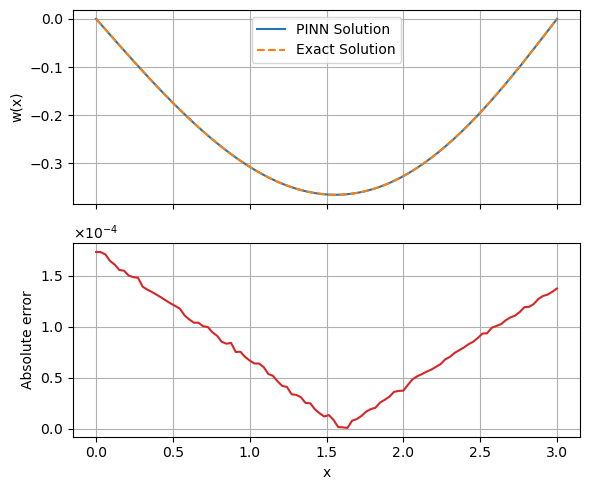

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x, u_pred, label="PINN Solution")
ax1.plot(x, u_exact, label="Exact Solution", linestyle="dashed")
ax1.set(ylabel='w(x)')
ax1.legend()
ax1.grid()

ax2.plot(x, abs_error, 'tab:red')
ax2.set(xlabel='x', ylabel='Absolute error')
ax2.grid()

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Defines when to switch to scientific notation

ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [16]:
# log_file = "pinn_experiments.csv"

# # Define the parameters to log
# experiment_data = {
#     "learning_rate": [adam_lr, lbfgs_lr],
#     "num_epochs": epochs,
#     "num_points": n_points,
#     "hidden_layers": layers[1:-1],
#     "weight_pde": w_pde,
#     "weight_bc": w_bc,
#     "final_loss": "{:.3e}".format(final_loss),
#     "max_abs_error": "{:.3e}".format(max_error),
#     "L2_error": "{:.3e}".format(u_error),
#     "train_time": "{:.3f}".format(trainning_time)
# }

# # Check if file exists to write the header only once
# file_exists = os.path.isfile(log_file)

# with open(log_file, mode="a", newline="") as file:
#     writer = csv.DictWriter(file, fieldnames=experiment_data.keys())
    
#     # Write the header if it's a new file
#     if not file_exists:
#         writer.writeheader()
    
#     # Write experiment data
#     writer.writerow(experiment_data)

# print("Experiment logged successfully!")